In [1]:
# Import Libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np


In [2]:
#Class Labels
labels_ = [ 
            'Speed limit (30km/h)', 
            'Speed limit (50km/h)', 
            'Speed limit (120km/h)', 
            'No passing', 
            'No passing veh over 3.5 tons', 
            'Priority road', 
            'Yield', 
            'Stop', 
            'No entry', 
            'Turn right ahead', 
            'Turn left ahead', 
            'Go straight or right', 
            'Go straight or left', 
]

In [3]:
#Defining function for plotting confusion matrix with Seaborn library
from sklearn.metrics import confusion_matrix

def conf_matrix(pred_labels, y_test):
    conf_mat = confusion_matrix(y_test,pred_labels)
    fig, ax = plt.subplots(figsize=(20,15))
    sn.heatmap(conf_mat, annot=True, fmt='d',xticklabels=labels_, yticklabels=labels_)
    plt.ylabel('Actual') 
    plt.yticks(rotation=0) 
    plt.xlabel('Predicted')
    plt.show()

In [4]:
### To test whether GPU instance is present in the system of not.
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)

Using PyTorch version: 1.11.0+cu113 CUDA: True


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
image_size = (32,32)

transformations = transforms.Compose(
        [transforms.Resize(list(image_size)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.5], std=[0.5])])

In [7]:
batch_size = 130 

train_set = datasets.ImageFolder('Train', transform = transformations)

# YOUR CODE HERE for the DataLoader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)

In [8]:
# Get input/output from data loader
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([130, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([130]) type: torch.LongTensor


In [9]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional Layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        # Dropout to avoid overfitting
        self.drop_out = nn.Dropout()

        # Fully connected layers
        self.fc1 = nn.Linear(512, 32)
        self.fc2 = nn.Linear(32, 13)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        # Flatten
        out = out.view(out.size(0), -1)

        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [11]:
# Declaring the loss function and optimizer

model = CNN()
model = model.to(device)
print(model)

#criterion = # YOUR CODE HERE : Explore and declare loss function
# loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.CrossEntropyLoss()

#optimizer = # YOUR CODE HERE : Explore on optimizer and define with the learning rate
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear

In [12]:
# YOUR CODE HERE. This will take time

# Record loss and accuracy of the train dataset
def train(epoch, log_interval=100):
    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data.float())
        target = Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = target.size(0)
        _, predicted = torch.max(output.data, 1)
        correct = (predicted == target).sum().item()        

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), (correct / total) * 100))

In [13]:
%%time
epochs = 6
lossv, accv = [], []
for epoch in range(1, epochs+1):
    train(epoch)
    # test(lossv, accv)

Train Epoch: 1 [0/17219 (0%)]	Loss: 2.787234	Accuracy: 3.08%
Train Epoch: 1 [13000/17219 (75%)]	Loss: 0.577680	Accuracy: 77.69%
Train Epoch: 2 [0/17219 (0%)]	Loss: 0.361356	Accuracy: 88.46%
Train Epoch: 2 [13000/17219 (75%)]	Loss: 0.277716	Accuracy: 90.00%
Train Epoch: 3 [0/17219 (0%)]	Loss: 0.177941	Accuracy: 95.38%
Train Epoch: 3 [13000/17219 (75%)]	Loss: 0.191156	Accuracy: 94.62%
Train Epoch: 4 [0/17219 (0%)]	Loss: 0.120627	Accuracy: 96.92%
Train Epoch: 4 [13000/17219 (75%)]	Loss: 0.057224	Accuracy: 97.69%
Train Epoch: 5 [0/17219 (0%)]	Loss: 0.101888	Accuracy: 96.92%
Train Epoch: 5 [13000/17219 (75%)]	Loss: 0.040709	Accuracy: 99.23%
Train Epoch: 6 [0/17219 (0%)]	Loss: 0.033211	Accuracy: 98.46%
Train Epoch: 6 [13000/17219 (75%)]	Loss: 0.055855	Accuracy: 97.69%
Wall time: 59 s


In [14]:
torch.save(model.state_dict(), 'conv_net_model.ckpt')

In [15]:
# Load the model
loaded_model = CNN()
loaded_model.load_state_dict(torch.load('conv_net_model.ckpt',map_location=device))
loaded_model.eval()


CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear

In [16]:
# Testing Evaluation for CNN model

val_set = datasets.ImageFolder('Test',transform = transformations)

# YOUR CODE HERE for the DataLoader
test_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=1)

In [17]:
# Get input/output from data loader
for (X_test, y_test) in test_loader:
    print('X_test:', X_test.size(), 'type:', X_test.type())
    print('y_test:', y_test.size(), 'type:', y_test.type())
    break

X_test: torch.Size([130, 3, 32, 32]) type: torch.FloatTensor
y_test: torch.Size([130]) type: torch.LongTensor


In [18]:
# YOUR CODE HERE for calculating the accuracy
loaded_model.eval()

loaded_model = model.eval()

correct = 0
total = 0

#Initalize empty tensor for storing predictions
predicted_np = torch.empty(0)

#Initialize empty tensor for storing labels from test data
test_labels_np = torch.empty(0)

#Transfer empty tensor to "device" (to CUDA if necesaary)
predicted_np , test_labels_np = predicted_np.to(device), test_labels_np.to(device)

for images, labels in test_loader:
    images = Variable(images.float())
    images, labels = images.to(device), labels.to(device)
    outputs = loaded_model(images)
    _, predicted = torch.max(outputs.data, 1)
    predicted_np = torch.concat((predicted_np,predicted))
    test_labels_np = torch.concat((test_labels_np,labels))
    total += labels.size(0)
    correct += (predicted == labels).sum()

#Transfer tensors with label, to cpu and convert to numpy arrays for further processings.
predicted_np = predicted_np.cpu().numpy()
test_labels_np = test_labels_np.cpu().detach().numpy()
print('Test Accuracy of the model on test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on test images: 97.0053 %


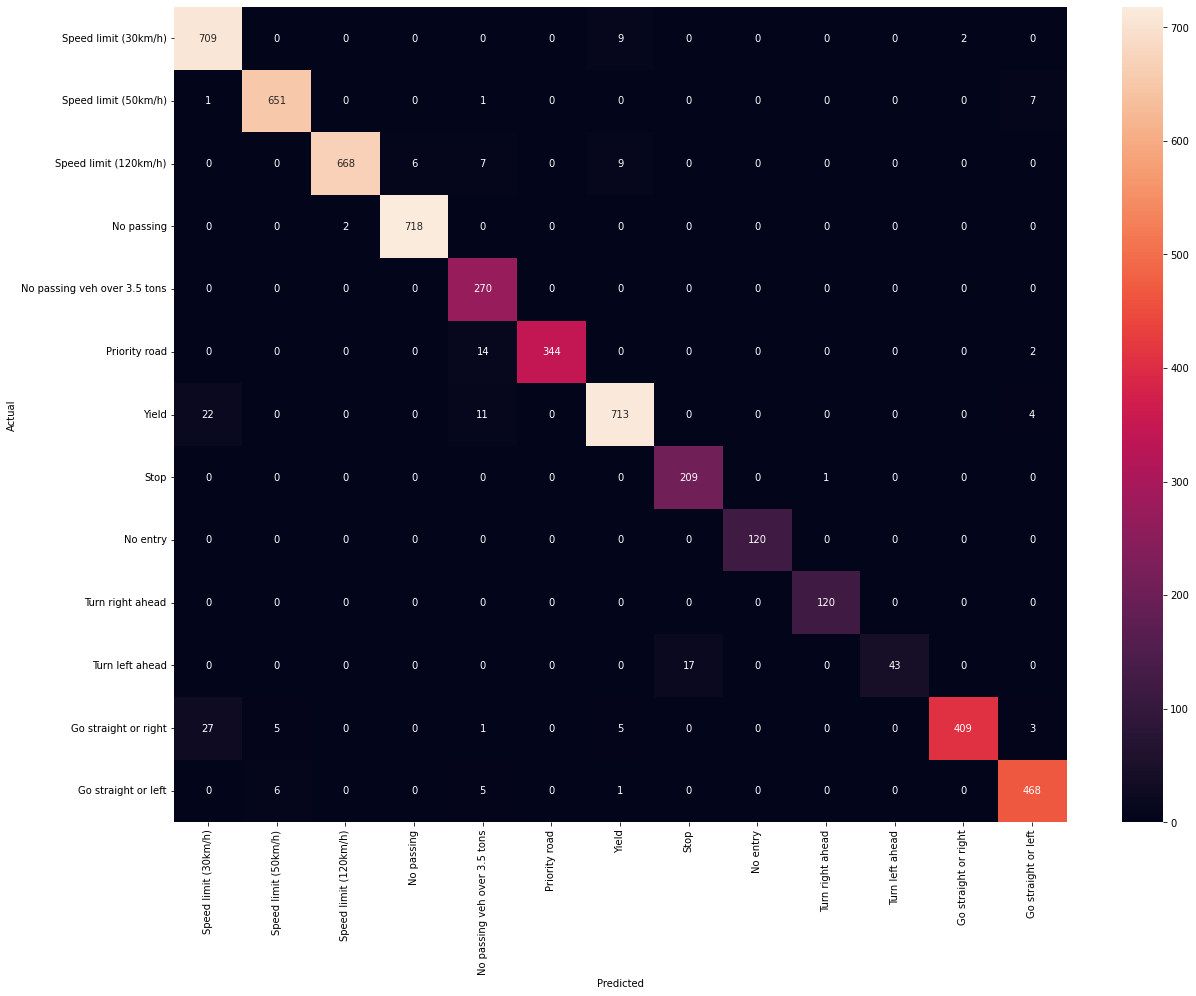

In [19]:
conf_matrix(predicted_np,test_labels_np)

100 EPOCH

In [28]:
# Declaring the loss function and optimizer

model = CNN()
model = model.to(device)
print(model)

#criterion = # YOUR CODE HERE : Explore and declare loss function
# loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.CrossEntropyLoss()

#optimizer = # YOUR CODE HERE : Explore on optimizer and define with the learning rate
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear

In [29]:
%%time
epochs = 100
lossv, accv = [], []
for epoch in range(1, epochs+1):
    train(epoch)
    # test(lossv, accv)

Train Epoch: 1 [0/17219 (0%)]	Loss: 2.655083	Accuracy: 6.92%
Train Epoch: 1 [13000/17219 (75%)]	Loss: 0.518243	Accuracy: 86.92%
Train Epoch: 2 [0/17219 (0%)]	Loss: 0.432241	Accuracy: 86.92%
Train Epoch: 2 [13000/17219 (75%)]	Loss: 0.154716	Accuracy: 96.15%
Train Epoch: 3 [0/17219 (0%)]	Loss: 0.096926	Accuracy: 97.69%
Train Epoch: 3 [13000/17219 (75%)]	Loss: 0.132308	Accuracy: 94.62%
Train Epoch: 4 [0/17219 (0%)]	Loss: 0.073138	Accuracy: 98.46%
Train Epoch: 4 [13000/17219 (75%)]	Loss: 0.053481	Accuracy: 98.46%
Train Epoch: 5 [0/17219 (0%)]	Loss: 0.062261	Accuracy: 97.69%
Train Epoch: 5 [13000/17219 (75%)]	Loss: 0.122695	Accuracy: 96.15%
Train Epoch: 6 [0/17219 (0%)]	Loss: 0.048146	Accuracy: 98.46%
Train Epoch: 6 [13000/17219 (75%)]	Loss: 0.050980	Accuracy: 98.46%
Train Epoch: 7 [0/17219 (0%)]	Loss: 0.082173	Accuracy: 96.92%
Train Epoch: 7 [13000/17219 (75%)]	Loss: 0.032719	Accuracy: 99.23%
Train Epoch: 8 [0/17219 (0%)]	Loss: 0.064663	Accuracy: 99.23%
Train Epoch: 8 [13000/17219 (75%)]	L

In [30]:
# YOUR CODE HERE for calculating the accuracy
loaded_model.eval()

loaded_model = model.eval()

correct = 0
total = 0

#Initalize empty tensor for storing predictions
predicted_np = torch.empty(0)

#Initialize empty tensor for storing labels from test data
test_labels_np = torch.empty(0)

#Transfer empty tensor to "device" (to CUDA if necesaary)
predicted_np , test_labels_np = predicted_np.to(device), test_labels_np.to(device)

for images, labels in test_loader:
    images = Variable(images.float())
    images, labels = images.to(device), labels.to(device)
    outputs = loaded_model(images)
    _, predicted = torch.max(outputs.data, 1)
    predicted_np = torch.concat((predicted_np,predicted))
    test_labels_np = torch.concat((test_labels_np,labels))
    total += labels.size(0)
    correct += (predicted == labels).sum()

#Transfer tensors with label, to cpu and convert to numpy arrays for further processings.
predicted_np = predicted_np.cpu().numpy()
test_labels_np = test_labels_np.cpu().detach().numpy()
print('Test Accuracy of the model on test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on test images: 99.2513 %


In [20]:
import torch
  
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
        
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.3
ID of current CUDA device: 0
Name of current CUDA device:NVIDIA GeForce GTX 1650 Ti


In [21]:
torch.backends.cudnn.version()

8200